# Alagotihm Chain
Data : adult.csv
target : income
preprocess :
1. Missing Value : simple imputer with constant
2. One Hot Encoding : relationship, race, sex
3. Binary Encoding : workclass, marital status, occupation, native country
4. Ordinal Encoding : education (already encoded)
5. No Treatment : numerical
6. Out : fnlwgt
Random state 10, data splitting 70:30


1. Model Tree (max depth 5, criterion entropy) and compute f1 using CV
2. Compute another metrics
3. Model Logistic Regression (solver liblinear) compute recall, precision, f1, make ROC and PRC in test set
4. Do hyperparameter tuning for logistic regression (optimize C and solver) optimized by f1 and using stratified CV 5 fold
5. Compare the result (before and after) in test set

> ## Library

In [1]:
!pip install category_encoders

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

# model
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# evaluation
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import f1_score, recall_score, precision_score, classification_report, plot_roc_curve, plot_precision_recall_curve

# preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
import category_encoders as ce # binary encoders
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

> ## Data

In [3]:
df_adult = pd.read_csv(r'C:\Users\user\Documents\Data Science\MODUL 3\Scaling\adult.csv')
df_adult

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,22,Private,310152,Some-college,10,Never-married,Protective-serv,Not-in-family,White,Male,0,0,40,United-States,<=50K
32557,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32558,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32559,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K


> ## Missing Value

In [4]:
df_adult.replace('?', np.nan, inplace = True)
df_adult

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,NaN,77053,HS-grad,9,Widowed,NaN,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,NaN,186061,Some-college,10,Widowed,NaN,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,22,Private,310152,Some-college,10,Never-married,Protective-serv,Not-in-family,White,Male,0,0,40,United-States,<=50K
32557,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32558,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32559,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K


In [5]:
df_adult.isnull().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education.num        0
marital.status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     583
income               0
dtype: int64

> ## Preprocess
1. Missing Value : simple imputer with constant
2. One Hot Encoding : relationship, race, sex
3. Binary Encoding : workclass, marital status, occupation, native country
4. Ordinal Encoding : education (already encoded)
5. No Treatment : numerical
6. Out : fnlwgt

In [6]:
binary_encoder_pipeline = Pipeline([
                                    ('imputer',SimpleImputer(strategy = 'constant',fill_value = 'NC')),
                                    ('binary encoder',ce.BinaryEncoder())
])

transformer = ColumnTransformer([
                                 ('one hot encoder',OneHotEncoder(drop = 'first'),['relationship','race','sex']),
                                 ('binary encoder',binary_encoder_pipeline,['workclass','marital.status','occupation','native.country'])
                                ], remainder = 'passthrough')

> ## Data Splitting

In [7]:
x = df_adult.drop(columns = ['fnlwgt', 'income', 'education'])
y = np.where(df_adult['income'] == '>50K', 1, 0)

In [8]:
x_train, x_test, y_train, y_test = train_test_split(x,
                y, 
                stratify = y,
                random_state = 10)

> ## Model Evaluation: Benchmark

In [9]:
skfold = StratifiedKFold(n_splits = 5)
tree = DecisionTreeClassifier(max_depth = 5, criterion = 'entropy', random_state = 10)

estimator = Pipeline([
    ('preprocess', transformer),
    ('model', tree)
])

In [10]:
tree_cv = cross_val_score(estimator, x_train, y_train, scoring = 'f1')

C:\Users\user\Anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\user\Anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\user\Anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\user\Anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
C:\Users\user\Anaconda3\lib\site-packages\category_encoders\util

In [11]:
tree_cv

array([0.6135094 , 0.61717172, 0.61113899, 0.61748358, 0.62020202])

In [12]:
import warnings
warnings.filterwarnings('ignore')

In [13]:
print('cross val : ', tree_cv)
print('cv score mean : ', tree_cv.mean())
print('cv score std : ', tree_cv.std())

cross val :  [0.6135094  0.61717172 0.61113899 0.61748358 0.62020202]
cv score mean :  0.6159011394046097
cv score std :  0.003194200777543969


> ## Another Model and Metrics

In [14]:
def model_evaluation_cv(model, metrics):
    skfold = StratifiedKFold(n_splits = 5)
    estimator = Pipeline([
    ('preprocess', transformer),
    ('model', model)
])
    
    model_cv = cross_val_score(estimator, x_train, y_train, scoring = metrics)
    print('cross val : ', model_cv)
    print('cv score mean : ', model_cv.mean())
    print('cv score std : ', model_cv.std())

In [15]:
logreg = LogisticRegression(solver = 'liblinear')
knn = KNeighborsClassifier(n_neighbors = 5)

In [16]:
model_evaluation_cv(logreg, 'f1')

cross val :  [0.64299424 0.65016659 0.64026718 0.63489037 0.67351705]
cv score mean :  0.6483670849291006
cv score std :  0.013504492796778896


In [17]:
model_evaluation_cv(logreg, 'recall')

cross val :  [0.56972789 0.58078231 0.57057823 0.56632653 0.61257434]
cv score mean :  0.5799978615065398
cv score std :  0.016987933532899492


In [18]:
model_evaluation_cv(knn, 'f1')

cross val :  [0.65723131 0.6600346  0.65443425 0.667259   0.68693009]
cv score mean :  0.6651778507211802
cv score std :  0.011683462929397925


> ## Model Benchmark : Logistic Regression

In [19]:
logreg = LogisticRegression(solver = 'liblinear')

estimator = Pipeline([
    ('preprocess', transformer),
    ('model', logreg)
])

In [20]:
estimator.fit(x_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one hot encoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['relationship', 'race',
                                                   'sex']),
                                                 ('binary encoder',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='NC',
                                                                                 strategy='constant')),
                                                                  ('binary '
                                                                   'encoder',
                                                                   BinaryEncoder())]),
                                    

In [21]:
y_pred = estimator.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.94      0.91      6181
           1       0.75      0.57      0.65      1960

    accuracy                           0.85      8141
   macro avg       0.81      0.76      0.78      8141
weighted avg       0.84      0.85      0.84      8141



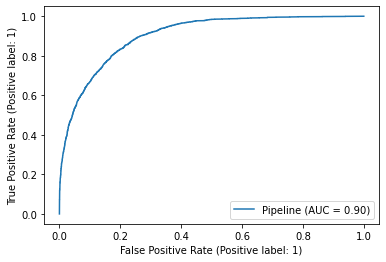

In [22]:
plot_roc_curve(estimator, x_test, y_test)

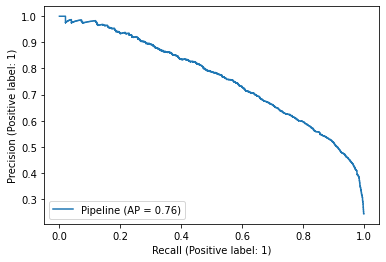

In [23]:
plot_precision_recall_curve(estimator, x_test, y_test)

> ## Hyperparameter Tuning using Pipeline

In [30]:
logreg = LogisticRegression(solver = 'liblinear', C = 1)

estimator = Pipeline([
    ('preprocess', transformer),
    ('model', logreg)
])

hyperparam_space = {
    'model__C': [100, 10, 1, 0.1, 0.001],
    'model__solver':['liblinear', 'newton-cg']
}

skfold = StratifiedKFold(n_splits = 5)

grid_search = GridSearchCV(estimator, 
                           param_grid = hyperparam_space, 
                           cv = skfold, 
                           scoring = 'f1', 
                           n_jobs = -1, )

In [31]:
grid_search.fit(x_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('one '
                                                                         'hot '
                                                                         'encoder',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['relationship',
                                                                          'race',
                                                                          'sex']),
                                                                        ('binary '
                                                                         'encoder',
                

In [32]:
print('score : ', grid_search.best_score_)
print('model : ', grid_search.best_params_)

score :  0.6518301336287953
model :  {'model__C': 100, 'model__solver': 'newton-cg'}


In [35]:
tuning_result = pd.DataFrame(grid_search.cv_results_)

In [39]:
tuning_result[(tuning_result['param_model__C'] == 1)&(tuning_result['param_model__solver'] == 'liblinear')]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__C,param_model__solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,2.156323,0.222846,0.108252,0.013311,1,liblinear,"{'model__C': 1, 'model__solver': 'liblinear'}",0.642994,0.650167,0.640267,0.63489,0.673517,0.648367,0.013504,5


In [40]:
tuning_result[(tuning_result['param_model__C'] == 1)&(tuning_result['param_model__solver'] == 'newton-cg')]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__C,param_model__solver,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,10.319952,0.66478,0.121429,0.02569,1,newton-cg,"{'model__C': 1, 'model__solver': 'newton-cg'}",0.647421,0.655939,0.641171,0.64194,0.66946,0.651186,0.01055,3


> ## Comparison Before & After Tuning

In [42]:
logreg = LogisticRegression(solver = 'liblinear')

estimator = Pipeline([
    ('preprocess', transformer),
    ('model', logreg)
])

estimator.fit(x_train, y_train)

y_pred = estimator.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.94      0.91      6181
           1       0.75      0.57      0.65      1960

    accuracy                           0.85      8141
   macro avg       0.81      0.76      0.78      8141
weighted avg       0.84      0.85      0.84      8141



In [43]:
estimator = grid_search.best_estimator_

estimator.fit(x_train, y_train)

y_pred = estimator.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      6181
           1       0.75      0.58      0.65      1960

    accuracy                           0.85      8141
   macro avg       0.81      0.76      0.78      8141
weighted avg       0.85      0.85      0.85      8141

